<a href="https://colab.research.google.com/github/AlessandroRizzetto/Visual-Grounding-Project/blob/main/visualGrounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project

| Matricola |   Name and Surname  | @                                 |
|-----------|---------------------|-----------------------------------|
|   239958  |   Pietro Fronza     | pietro.fronza@studenti.unitn.it   |
|   239953  |   Simone Compri     | simone.compri@studenti.unitn.it   |
|   247542  | Alessandro Rizzetto | alessandro.rizzetto@studenti.unitn.it|


The task we aimed to accomplish in this assignment is visual grounding. Visual Grounding (VG) is the process of identifying the most relevant object or region in an image based on a natural language query, which can be a phrase, a sentence, or even a multi-round dialogue. To achieve this, we utilized the RefCOCOg dataset, YOLO, and CLIP.

This report presents two solutions to the proposed challenge: a baseline approach that addresses the task using a rudimentary combination of YOLO and CLIP, and the ExtendedClip network, which strives to overcome the limitations of the basic version.

The notebook is structured as follows:

* Environment SetUp: Installation, importing necessary packages, and defining system paths.
* Metric Definition and Dataset Initialization.
* Baseline Definition.
* ExtendedClip Solution Definition.
* Training and Testing of ExtendedClip.
* Evaluation of the models.
* Conclusion and Future Works.

#Environment SetUp

In [ ]:
def is_running_on_colab():
  """Check if the environment of execution is Google Colab or not"""
  try:
    # If we ar not in colab the google. colab library cannot be imported
    import google.colab
    return True
  except ImportError:
    return False

In [ ]:
colab_env = is_running_on_colab()

##Install required packages

In [ ]:
!pip install ultralytics
!pip install git+https://github.com/openai/CLIP.git
!pip install textdistance
!pip install pycocotools
!pip install gdown

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7kh5tygt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7kh5tygt
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


##Import libraries

In [ ]:
import os
import clip
import pickle
import numpy as np
from PIL import Image
from enum import Enum
import textdistance as td
from ultralytics import YOLO
from pycocotools.coco import COCO

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision.transforms as T
from torchvision.ops import box_convert
from torchvision.datasets import VisionDataset

if colab_env:
  from google.colab import drive

# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"

##Paths definition

In [ ]:
## Dataset
# Base folder of Google drive
drive_root = '/content/drive'
# Name of the tar.gz file which contains the dataset
tar_file = 'refcocog.tar.gz'
# Directory where the dataset will be extract
data_dir = './refcocog/'
# URL for downloading the tar.gz file
dataset_url = 'https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq'

# YOLO
## Yolo model file
yolo_path = "yolov8n.pt"

##Dataset Loading

In [ ]:
# Mount Google Drive directory if we are in Google Colab
if colab_env and not os.path.ismount(drive_root):
  drive.mount(drive_root)

# Download dataset file if not present
if not os.path.isfile(tar_file):
  !gdown {dataset_url}

# Extract dataset if not already extracted
if not os.path.exists(data_dir):
  !tar xvzf {tar_file}

## Custom Dataset

Given the project objectives and the defined task, the dataset utilized is RefCOCOg. This dataset comprises 85,474 referring expressions for 54,822 objects across 26,711 images. Specifically, these images were selected to contain between two and four objects of the same category [1].

As observed in the image below, RefCOCOg, unlike RefCOCO and RefCOCO+, tends to provide more elaborate and florid language. Moreover, expressions within the dataset have an average length of 8.43 words, significantly higher compared to the other two datasets, which have an average around 3.5 words.






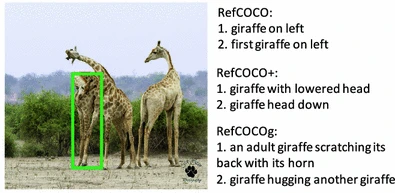

*Figure 1: Example referring expressions for the giraffe outlined in green from three referring expression datasets*

In order to create a custom dataset useful for us, the class is an extension of the `torchvision.datasets.VisionDataset` class to make our dataset compatible with `torchvision`. In fact, our aim is to create a dataset that provides data compatible with this library, since our system uses its functions.

With regard to the data used, we take into account the files `instances.json`, used to retrieve images references and bounding boxes, and `refs(umd).p`, used for captions.
More precisely, when the class is initialized, we first clean the dataset, starting using data of `instances.json`, from annotations without a correspondence with an actual image (looking also for the required data based on the split). In this way we create a "mapping" of the interested ids in the `elements_map` array (e.g., index 0 of the array now represent the image with id 524297). Moreover, we trasform the array obtained from `refs(umd).p` in a dictionary with the images ids as key linked to an array of captions to make the search of the caption easier later.

The research (i.e., the `__getitem__` method) in the dataset is managed initially using the APIs provided by COCO, which finds and loads the image and the bounding boxes correlated to the given id (obtained from its "mapped id"). Then, for each bounding box, we take any connected caption, if any (in that case we take `None`), and create an object to associate them. At the end of this process, we add an object also for those captions that do not have a corresponding bounding box that remains (putting `None` in the associated property).

Finally, in the class are provided methods to handle single functions, like the adaptation of a bounding box.

In [ ]:
class CustomDataset(VisionDataset):

  def __init__(self, root, split='train', transform=None, target_transform=None, cache: bool = False):
    """Custom dataset init

    Args:
        root (string): dataset path
        split (string): data split ('test', 'train', 'val')
    """
    # Paths
    self.annotation_dir = '{}annotations'.format(root)
    self.imgs_dir = '{}images'.format(root)
    # COCO images-bboxes dataset
    self.coco = COCO(os.path.join(self.annotation_dir,'instances.json'))
    # COCO images-annotation dataset
    pickle_file = open(os.path.join(self.annotation_dir,'refs(umd).p'),'rb')
    tmp_coco_p = pickle.load(pickle_file)
    self.coco_p = {}
    # Creation of a dictionary<image_id-captions_array> to reduce the cost of the research of captions
    for i in tmp_coco_p:
      try:
        self.coco_p[i['image_id']].append(i)
      except:
        self.coco_p[i['image_id']] = [i]
    # Transforms
    self.transform = transform
    self.target_transform = target_transform
    # Cache
    self.cache = cache
    self._data = None
    if self.cache:
        self._data = [None] * len(self.coco.imgs)

    # Mapping of elements (Clean up of the dataset, in order to keep only the elements of the proper split and with an association dataset_record-image)
    self.elements_map = np.array([id
      if
        os.path.exists(os.path.join(self.imgs_dir,self.coco.loadImgs(int(id))[0]["file_name"]))
        and self.coco_p[id][0]['split'] == split
      else None
      for id in list(self.coco.imgs)])
    self.elements_map = self.elements_map[self.elements_map != np.array(None)]
    '''Extended version of the clean up
    self.elements_map = np.array(list(self.coco.imgs))
    elements_map_mask = [False]*len(self.elements_map)
    for (i,id) in np.ndenumerate(self.elements_map):
      image_path = self.coco.loadImgs(int(id))[0]["file_name"]
      if os.path.exists(os.path.join(self.imgs_dir,image_path)):
        elements_map_mask[i[0]] = True
    mask = np.array(elements_map_mask, dtype=bool)
    self.elements_map = self.elements_map[mask]'''

  def __len__(self):
    return len(self.elements_map)

  def __getitem__(self, idx):
    # Return cahced element if present
    if self.cache and self._data[idx]:
        return self._data[idx]

    # Retrieve and load PIL image
    id = self.elements_map[idx]
    img_data = self.coco.loadImgs(ids=id)[0]
    image, original_width, original_height = self.load_image(id)

    # Resize the image loaded to a standard size
    desired_size = (640, 640)
    image = image.resize(desired_size, Image.ANTIALIAS)
    # Apply transform to image
    if self.transform:
      image = self.transform(image)

    # Get bboxes
    bb_ann_ids = self.coco.getAnnIds(imgIds=img_data['id']);
    bb_anns = self.coco.loadAnns(bb_ann_ids)
    #Get captions
    cap_anns = self.coco_p[id]
    cap_anns_copy = cap_anns[:]
    # Merge bboxes with captions to obtain annotations
    anns = []
    for bb in bb_anns:
      # Bounding box resize
      bb['bbox'] = self.adapt_bbox(bb['bbox'], original_width, original_height)
      # Captions linked to the bounding box
      cap = next(((idx, c) for (idx, c) in enumerate(cap_anns_copy) if c['ann_id'] == bb['id']), None)
      if cap is not None:
        # Captions present
        anns.append({
            'id': bb['id'],
            'bbox': bb['bbox'],
            'caption': cap[1]['sentences']
        })
        cap_anns_copy.pop(cap[0])
      else:
        # Captions not present
        anns.append({
            'id': bb['id'],
            'bbox': bb['bbox'],
            'caption': None
        })
    # Addition of captions without a bounding box
    if len(cap_anns_copy) != 0:
      for cap in cap_anns_copy:
        anns.append({
            'id': cap['ann_id'],
            'bbox': None,
            'caption': cap['sentences']
        })

    # Apply transform to annotations
    if self.target_transform:
        anns = self.target_transform(anns)

    # Insert new element in cache
    sample = image,anns
    if self.cache:
        self._data[id] = sample

    return sample

  def adapt_bbox(self, bbox, original_width, original_height):
      """
      Converts bbox from format xywh into xyxy and rescales its values
      between 0 and 224.
      return: bbox

      """
      x, y, w, h = bbox
      new_width, new_height = 640, 640

      # Calculate the scaling factors for width and height
      width_scale, height_scale = new_width / original_width, new_height / original_height

      # Scale and convert the bounding box coordinates
      bbox = [x * width_scale, y * height_scale, (x + w) * width_scale, (y + h) * height_scale]

      return bbox

  # Function to load images from coco dataset
  def load_image(self, ref: int):
      """
      Loads the image corresponding to the given reference.
      return: image, width, height
      """
      # Get the image path
      image_path = self.coco.loadImgs(ref)[0]["file_name"]
      image = Image.open(os.path.join(self.imgs_dir, image_path)).convert("RGB")
      width, height = image.size

      return image, width, height

  # Function to load the bounding box from coco dataset
  def load_bbox(self, ref: int):
      """
      Loads the bounding box corresponding to the given reference.
      return: bbox
      """
      # Get the annotation id
      ann_id = self.coco.getAnnIds(ref)
      # Get the annotation
      ann = self.coco.loadAnns(ann_id)[0]
      # Get the bounding box
      bbox = ann["bbox"]

      return bbox

  # Function to load the caption from coco dataset
  def load_caption(self, ref: int):
      """
      Loads the caption corresponding to the given reference.
      return caption
      """
      # Get the annotation id
      ann_id = self.coco.getAnnIds(ref)
      # Get the annotation
      ann = self.coco.loadAnns(ann_id)[0]
      # Get the caption
      caption = ann["caption"]

      return caption

In [ ]:
dataset = CustomDataset(data_dir)

loading annotations into memory...
Done (t=10.01s)
creating index...
index created!


# Usefull Functions

The `getBbox_fromYOLO` function utilizes YOLO to predict bounding boxes for an input image. \\
It extracts the bounding boxes from the model's results, filters out invalid boxes, and optionally converts the result into a PyTorch tensor. \\
The function finally returns a list or tensor of predicted bounding boxes.

In [ ]:
def getBbox_fromYOLO(yoloModel, image, tensor=True):

    # Get the bounding box from YOLOv8
    results = yoloModel(image, verbose=False)
    # Get a list of bounding box
    bboxes = [ result.xyxy[0].cpu().numpy() for result in results[0].boxes] # in contrast to the documentation, yoloModel gives an array with the actual result in the first position (I don't know when there are more than one element)
    # Check if extracted bounding boxes are possible, given the image size
    bboxes = [ bbox for bbox in bboxes if bbox[0] != bbox[2] and bbox[1] != bbox[3] ]
    if tensor:
      bboxes = torch.tensor(bboxes)

    return bboxes

## Metrics Definitions

The `Metrics` class contains a method named `bboxes_iou`, which calculates the **Intersection over Union** (IoU) between two bounding boxes.

<center>

$$
\text{Intersection Over Union (IoU)} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

</center>

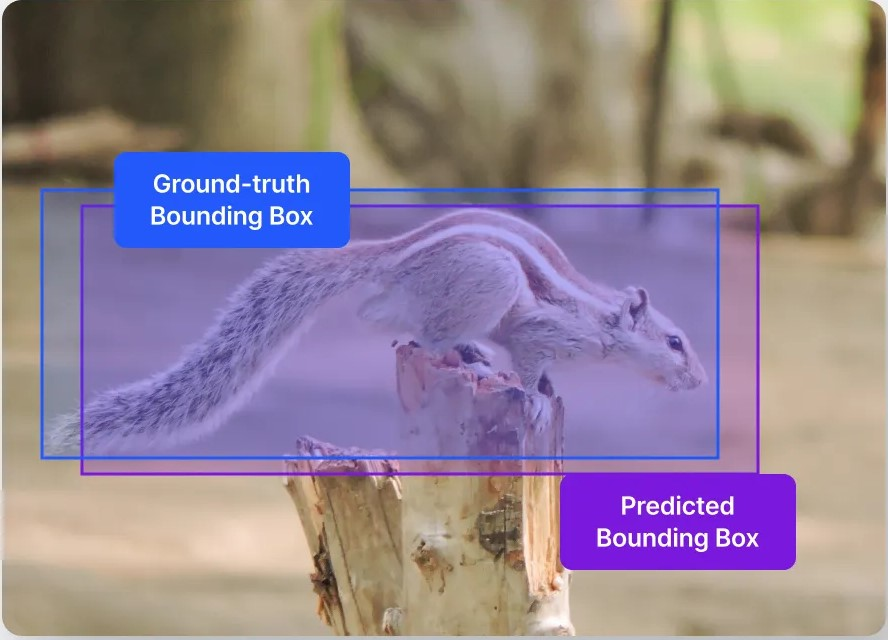

*Figure 2: Example of the Ground-truth and predicted Bounding Boxes on the image of a squirrel*

The function takes two bounding boxes (`box1` and `box2`) as input and an optional flag `tensor` to determine whether the result should be returned as a PyTorch tensor. \\
The method computes the intersection area and the union area of the two bounding boxes and then calculates the IoU using these values. If the intersection area is non-positive or either of the box areas is non-positive, the IoU is set to 0. The result is returned as either a regular numeric value or a PyTorch tensor based on the `tensor` flag.

In [ ]:
class Metrics():
  def bboxes_iou(box1, box2,tensor=False): #xyxy[0] boxes
    # Calculate intersection area
    intersection_width = min(box1[2], box2[2]) - max(box1[0], box2[0])
    intersection_height = min(box1[3], box2[3]) - max(box1[1], box2[1])

    if intersection_width <= 0 or intersection_height <= 0:
      if tensor:
        iou = torch.tensor(0)
      else:
        iou = 0
    else:
      # Calculate union area
      box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
      box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

      if box1_area > 0 and box2_area > 0:

        intersection_area = intersection_width * intersection_height

        union_area = box1_area + box2_area - intersection_area

        # Calculate IoU
        iou = intersection_area / union_area
      else:
        if tensor:
          iou = torch.tensor(0)
        else:
          iou = 0
    return iou

## Dataset Initialization


The default collate function is not able to manipulate the RefCOCOg dataset correctly, which is why it is necessary to create a custom function suited to our purpose.
Given a batch of elements as input, the function takes care of creating two lists: one of images and one containing the corresponding annotations.

In [ ]:
def cd_collate_fn(batch):
  imgs = [item[0] for item in batch]
  anns = [item[1] for item in batch]

  return imgs, anns

The `get_data` function takes care of defining the three splits used in the project and implementing the dataloaders.
In particular, the splits are defined on the basis of our customised version of RefCOCOg, creating the subdivisions on the basis of the labels assigned to the samples present to ensure the consistency and reproducibility of the results. \\
To train the model on a smaller number of samples, a subset of the training set of 1,500 items is also defined.

Finally, the dataloaders are instantiated using the customised collate function (`cd_collate_fn`) to handle the dataset-specific collate requirements, as defined above. \\
`Train_loader` provides the parameter `shuffle = True` to ensure regularisation while validation and testing are not mixed to allow reliable comparisons.

In [ ]:
# splittare il dataset e creare i dataloaders
def get_data(batch_size=68, test_batch_size=256, device="cuda"):
  # Initialize datasets for every split
  training_data = CustomDataset(data_dir)
  validation_data = CustomDataset(data_dir, 'val')
  test_data = CustomDataset(data_dir, 'test')

  # Create subsets to have a faster computation
  print("Total samples in training: ",len(training_data))
  print("Total Samples in validation: ",len(validation_data))
  print("Total Samples in test: ",len(test_data))

  # Create a subset of the training data
  training_data = Subset(training_data, range(1500))
  print("Samples used in training: ",len(training_data))

  # Initialize dataloaders
  train_loader = DataLoader(training_data, batch_size, shuffle=True, collate_fn=cd_collate_fn)
  validation_loader = DataLoader(validation_data, batch_size, shuffle=False, collate_fn=cd_collate_fn)
  test_loader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=cd_collate_fn)

  return train_loader, validation_loader, test_loader

# Baseline

To gain a comprehensive understanding of the issue and to provide a benchmark for comparison with our model, we developed a Baseline Model that integrates YOLO (You Only Look Once) and CLIP in a straightforward manner.

YOLO, an acronym for You Only Look Once, is a widely used real-time object detection and image segmentation model. \\
It is a powerful tool that distinguishes itself from previous detection systems by not requiring the application of the model at multiple locations and scales within an image. YOLO adopts a unique approach, employing a single neural network for the entire image. This network partitions the image into regions and predicts bounding boxes and probabilities for each region. The predicted probabilities are used to weight the corresponding bounding boxes.

Contrary to the suggested approach in the assignment description, we opted for YOLOv8 instead of YOLOv5. \\
YOLOv8 represents the latest version of the algorithm, and according to tests conducted by its creators, as documented on the [GitHub page](https://github.com/ultralytics/ultralytics), it demonstrates superior detection capabilities, faster processing, and lower computational demands.

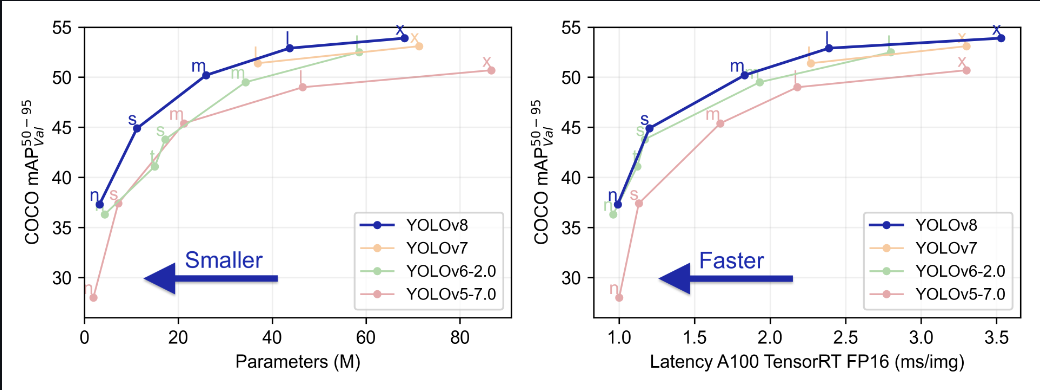

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. \\
Traditional image models typically involve the joint training of an image feature extractor and a linear classifier, with the aim of predicting specific labels. In contrast, CLIP adopts a unique approach by jointly training an image encoder and a text encoder. This joint training is designed to predict the correct pairings within a batch of training examples. \\
During the testing phase, the text encoder, having acquired knowledge during training, creates a zero-shot linear classifier. This is achieved by embedding the names or descriptions of the classes pertaining to the target dataset.




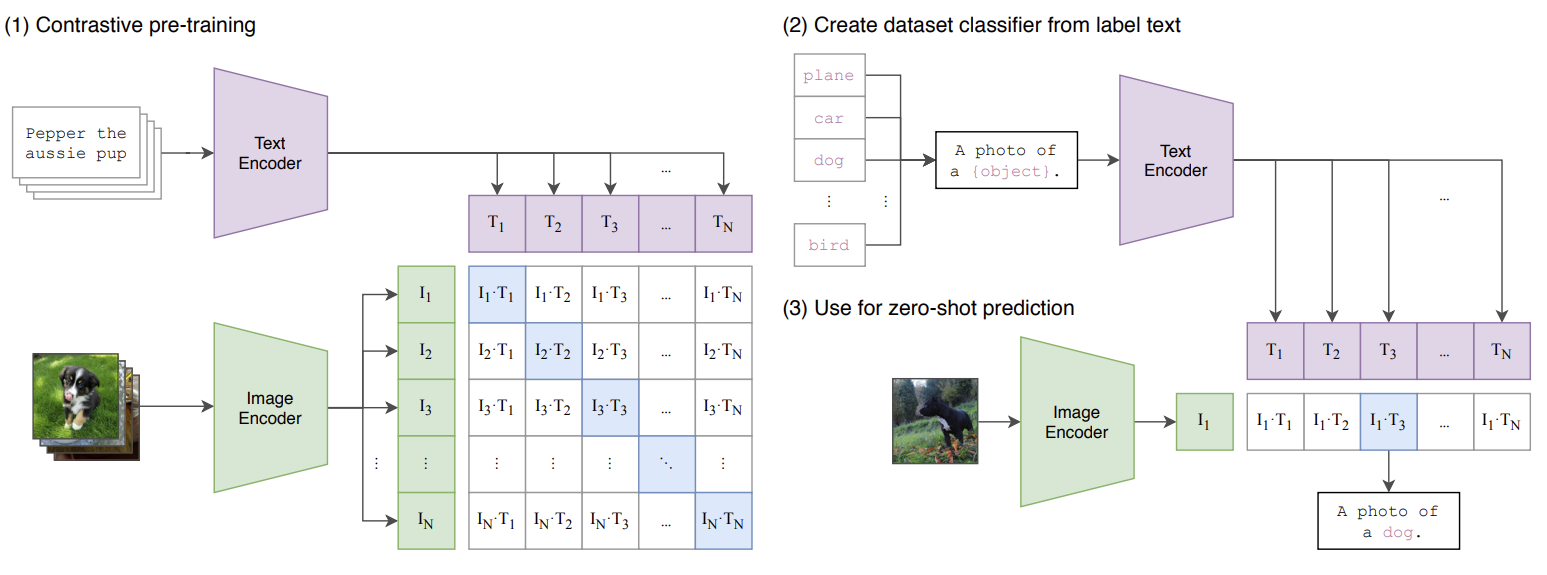

To strive for the most accurate replication of the state-of-the-art, we have opted to utilize pretrained versions of both YOLO and CLIP. We view these pretrained models as a sound starting point for the development of our own model. By leveraging these pretrained versions, we aim to build upon the advancements achieved in the current state-of-the-art, ensuring a robust foundation for the refinement and enhancement of our model.

We propose a schema representing the main steps of the baseline model, where it uses the bounding boxes highlighted by YOLO and evaluates their similarity with a textual query using CLIP. The process involves utilizing YOLOv8 on the original image to detect various elements present within it. The object is then cropped into several pieces related to the bounding boxes detected and compared with a textual embedding of the description provided into a shared latent space provided by CLIP. \\
In this way we can enable a comparison between textual and image representation, allowing to identify the best match object from the list provided by YOLO based on their similarity.

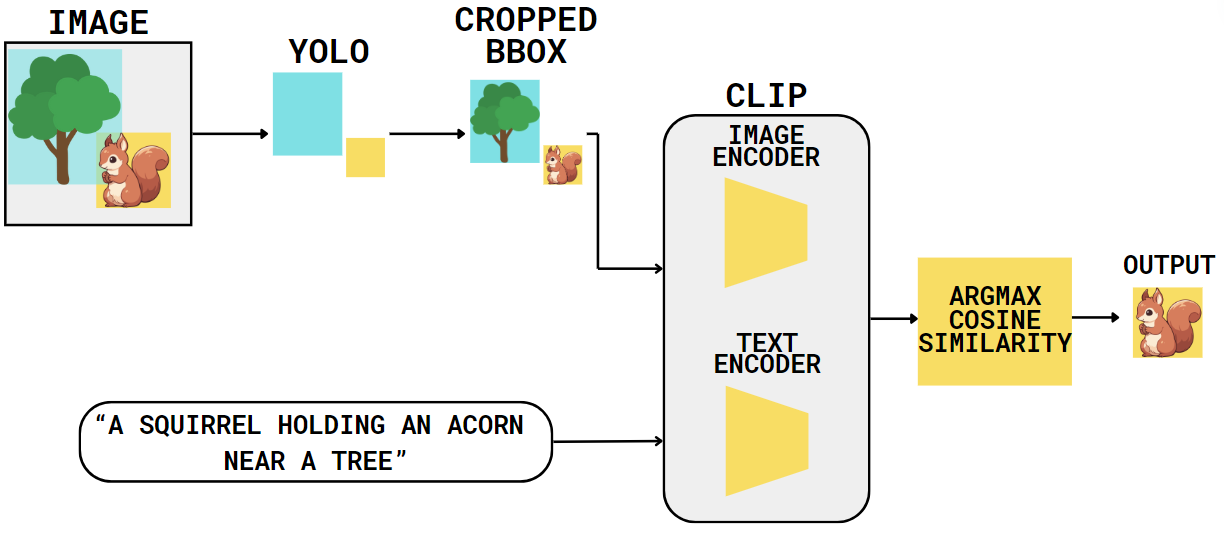

In [ ]:
class Baseline():

  def __init__(self, device=None):
    ''' Baseline init method
    '''
    if device is None:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
      self.device = device

    # Yolo model initialization
    self.yoloModel = YOLO(yolo_path).to(self.device)
    # Clip model initialization
    self.clipModel, self.preprocess = clip.load("RN50", device=self.device)


  def inference(self, image, text):
    '''
      Execute the code and returns a bounding box in the format 'xyxy'.
      If no bounding box is founded by YOLO, the method will return a bounding box coveing the whole image.

      Args:
        - image: a PIL image object
        - text: a textual description of what is needed to be found in the image
    '''
    # =============== YOLO ===============
    img = image

    # get YOLO bounding boxes
    yolo_results = getBbox_fromYOLO(self.yoloModel, img)

    # if YOLO did not found any bounding box stop here and return a bounding box covering the whole image
    if len(yolo_results) == 0:
      return torch.tensor([0, 0, 640, 640], device = self.device)

    # if there are some bounding boxes detected, create a list of cropped images, one per each bounding box
    cropped_images = self.get_cropped_images(img, yolo_results)

    # =============== CLIP ===============
    # preprocess all cropped images into a single tensor
    preprocessed_images = self.preprocess_images(cropped_images)

    tokenized_text = clip.tokenize([text]).to(self.device)

    # latent representations of the cropped images and text to search
    with torch.no_grad():
      image_features = self.clipModel.encode_image(preprocessed_images)
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features = self.clipModel.encode_text(tokenized_text).float()
      text_features /= text_features.norm(dim=-1, keepdim=True)

    # compute cosine similarity between each pair of image and text
    similarities = []
    for i in range(image_features.shape[0]):
      cos = torch.nn.CosineSimilarity(dim=-1)
      sim = float(cos(image_features[i,:], text_features).item())
      similarities.append(sim)

    best_bbox = np.argmax(similarities)

    pred_bbox = yolo_results[best_bbox]

    return torch.tensor(pred_bbox, device = self.device)

  def get_cropped_images(self, image, yolo_results):
    '''
      With the results returned from YOLO, the method returns a list of images that
      results from a cropping of them according to the bounding boxes founded in the image.

      Args:
        - image: the image used in the execution
        - yolo_results: list of bounding boxes returned by yolo on the image inputed
    '''
    cropped_images = []

    # get cropped image around the bounding boxes returned by yolo
    for i in range(len(yolo_results)):
      # convert YOLO boxes from xyxy format to xywh since box_convert works only with 'xywh' format
      bbox = yolo_results[i]
      converted_bbox = box_convert(bbox, 'xyxy', 'xywh')

      # crop image around area and push it into the cropped_images list
      cropped = T.functional.crop(image, int(converted_bbox[1].item()), int(converted_bbox[0].item()), int(converted_bbox[3].item()), int(converted_bbox[2].item()))
      cropped_images.append(cropped)

    return cropped_images

  def preprocess_images(self, images):
    '''
    Preprocess a list of images, by stacking them into a single tensor. E.g., if the method
    takes in input a list of 3 images, the resulting tensor will be of size [3,3,224,224], i.e.
    the first dimension represent the number of images, and the other three are components of the CLIP preprocess on image.
    Those are in order: number of color planes (for CLIP is 3 in RGB), and the other 2
    describe the width and height of each image. CLIP works with squared images of predefined size.
    '''
    # the preprocess of CLIP of each cropped image converts it into an image of size [3,224,224]
    preprocessed_images = []

    for image in images:
      # Preprocess single image and append it to the preprocessed_images list
      processed_img = self.preprocess(image).to(self.device)
      preprocessed_images.append(processed_img)

    # stack all cropped images into a single tensor. If we have n cropped images, it will be of size [n, 3, 224, 224]
    return torch.stack(preprocessed_images).to(self.device)

## Let's try the Baseline!

<ipython-input-34-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


(640, 640)
[{'id': 318235, 'bbox': [16.31, 211.1551401869159, 437.6, 522.5420560747664], 'caption': None}, {'id': 319598, 'bbox': [299.12, 204.23177570093458, 540.8199999999999, 337.0915887850467], 'caption': [{'tokens': ['a', 'bed', 'in', 'the', 'bedroom', 'with', 'other', 'bed', 'also', ',', 'on', 'its', 'right', 'side'], 'raw': 'A bed in the bedroom with other bed also, on its right side', 'sent_id': 40173, 'sent': 'a bed in the bedroom with other bed also , on its right side'}, {'tokens': ['a', 'long', 'bed', 'at', 'the', 'side', 'of', 'wall'], 'raw': 'a long bed at the side of wall', 'sent_id': 40174, 'sent': 'a long bed at the side of wall'}]}, {'id': 1174042, 'bbox': [320.05, 370.9158878504673, 399.94, 495.13271028037383], 'caption': None}, {'id': 1630619, 'bbox': [271.43, 283.5289719626168, 285.65000000000003, 290.781308411215], 'caption': None}, {'id': 1957252, 'bbox': [319.05, 292.5757009345794, 503.59000000000003, 440.52336448598135], 'caption': None}]
[16.31, 211.1551401869

<ipython-input-20-11cfb3873524>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(pred_bbox, device = self.device)


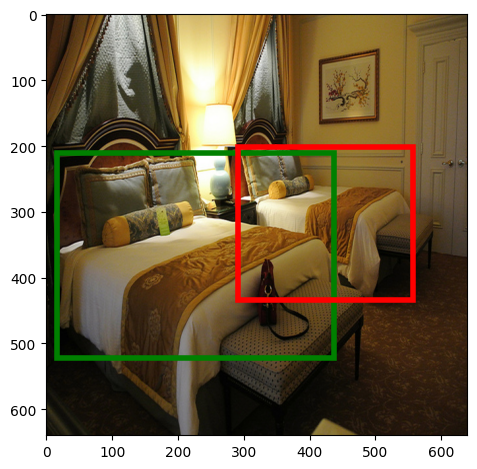

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

image, ann = dataset[0]

print(ann)
gt_bbox = ann[0]['bbox']
print(gt_bbox)

cap_1 = ann[1]['caption'][0]['raw']
print(cap_1)

# Init the baseline
baseline = Baseline()

# Inference
predicted = baseline.inference(image, cap_1)

I = np.asarray(image)

plt.imshow(I)
plt.gca().add_patch(Rectangle((gt_bbox[0], gt_bbox[1]), (gt_bbox[2]-gt_bbox[0]), (gt_bbox[3]-gt_bbox[1]), edgecolor="green", facecolor="none", lw=4))
plt.gca().add_patch(Rectangle((predicted[0].item(), predicted[1].item()),(predicted[2].item()-predicted[0].item()), (predicted[3].item()-predicted[1].item()),edgecolor="red",facecolor="none",lw=4))
plt.tight_layout()
plt.show()

<ipython-input-34-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


[{'id': 10608, 'bbox': [279.7, 223.6694835680751, 628.24, 633.5399061032863], 'caption': [{'tokens': ['standing', 'dog'], 'raw': 'standing dog', 'sent_id': 46507, 'sent': 'standing dog'}, {'tokens': ['a', 'black', 'and', 'white', 'dog', 'with', 'a', 'blue', 'collar', 'tag', 'who', 'is', 'standing', 'and', 'staring', 'at', 'something'], 'raw': 'A black and white dog with a blue collar tag who is standing and staring at something.', 'sent_id': 46508, 'sent': 'a black and white dog with a blue collar tag who is standing and staring at something'}]}, {'id': 16521, 'bbox': [0.0, 348.21408450704223, 285.83, 513.3821596244131], 'caption': [{'tokens': ['a', 'black', 'and', 'white', 'dog', 'laying', 'down', ',', 'looking', 'away', 'from', 'the', 'camera'], 'raw': 'A black and white dog laying down, looking away from the camera.', 'sent_id': 92321, 'sent': 'a black and white dog laying down , looking away from the camera'}, {'tokens': ['a', 'black', 'and', 'white', 'dog', 'looks', 'away', 'into'

<ipython-input-20-11cfb3873524>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(pred_bbox, device = self.device)


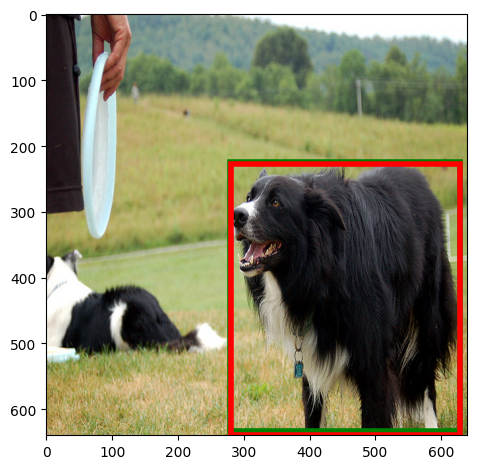

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

image, ann = dataset[1]
print(ann)
gt_bbox = ann[0]['bbox']
print(gt_bbox)
cap_1 = ann[0]['caption'][0]['raw']
print(cap_1)

# Init the baseline
baseline = Baseline()

# Inference
predicted = baseline.inference(image, cap_1)

I = np.asarray(image)

plt.imshow(I)
plt.gca().add_patch(Rectangle((gt_bbox[0], gt_bbox[1]), (gt_bbox[2]-gt_bbox[0]), (gt_bbox[3]-gt_bbox[1]), edgecolor="green", facecolor="none", lw=4))
plt.gca().add_patch(Rectangle((predicted[0].item(), predicted[1].item()),(predicted[2].item()-predicted[0].item()), (predicted[3].item()-predicted[1].item()),edgecolor="red",facecolor="none",lw=4))
plt.tight_layout()
plt.show()

# Our Solution

Since our task is to improve the visual grounding task tackled by the CLIP creators in their paper [[2]](https://arxiv.org/pdf/2103.00020.pdf), we considered the idea of extending the CLIP image and text encoders using a Multi Layer Perceptron.

In order to better refine the encoding of images and texts offered by CLIP, we decided to add two separate MLPs, which are going to be discussed in the following sections.

## Extended Image Encoder

The first encoder we present is an extension of the CLIP image encoder.
This network uses the CLIP model initialized with an RN50 in order to encode the preprocessed images that are given to it.

Together with the CLIP image encoder we also append 4 linear layers. Those layers are going to take the image encoding of CLIP (that is composed by 1024 features) and are going to rescale them into a smaller number of features. In this way we ensure that the features encoded in the images passed down this extended encoder have a meaningful representation of the most important features.

We decided to use a ReLU activation function between each layer in order to introduce some non linearity into the model. The ReLU activation function is one of the common activation function used in a Deep Learning architecture, especially for the ones with an higher number of layers due to the _vanishing gradient_ problem.

Since the encoding of the image is a crucial part in our workflow, it is important to ensure that the training process is able to encode the features in the right way.

We also add a casting of the input: the CLIP image encoder transform the image into a latent space representation, that is made by float16 values. The Linear layer of the `torch.nn` library works exclusively with float32 values, hence our choice to cast the input tensor into a float32 tensor after the CLIP image encoding.

In [ ]:
class Extended_Clip_img_enc(torch.nn.Module):
  def __init__(self):
    '''
    Init method of the Extended CLIP image encoder
    '''
    super().__init__()
    # Get CLIP model
    clip_model, _ = clip.load("RN50")

    # Get the visual encoder of CLIP
    self.clip_img_encoder = clip_model.encode_image

    # Create 4 linear layers
    self.layer_1 = nn.Linear(1024, 512)
    self.layer_2 = nn.Linear(512, 256)
    self.layer_3 = nn.Linear(256, 512)
    self.layer_4 = nn.Linear(512, 1024)

  def forward(self, net_input):
    # visual encoder
    with torch.no_grad():
      net_input = self.clip_img_encoder(net_input)
    # ---
    net_input = net_input.to(torch.float32)
    # first layer
    net_input = self.layer_1(net_input)
    net_input = F.relu(net_input)
    # second layer
    net_input = self.layer_2(net_input)
    net_input = F.relu(net_input)
    # third layer
    net_input = self.layer_3(net_input)
    net_input = F.relu(net_input)
    # fourth layer
    net_input = self.layer_4(net_input)
    # ---
    return net_input

## Extended Text Encoder

Now we present the extended version of the CLIP text encoder we developed.

As we did for the extended image encoder, we use the CLIP text encoder build on an RN50 in order to encode the preprocessed text we pass to it.

Together with the CLIP text encoder we use 2 more linear layers, that once again are going to refine the image encoding of CLIP in order to enlight the most important features of the text.

We decided to use only two layers w.r.t. the image encoding since the CLIP text encoding works in the following way: given a text of *n* tokens, the text encoding will convert the tokens into a 1024 sized tensor where the first *n* components are the corresponding value in the latent space and the following *1024-n* are encoded as 0 values.

To avoid that the most important features are going to be mixed together with too many zero values, thus vanishing them away, we decided to have only a couple of linear layers that simply split in half the number of features and then return them to the original size.

In addition, since the network is very simple and small, we decided to use a sigmoid activation function. In this way, since the value that correspond to most significant tokens will have higher values in the latent space representation, and thus an activation value closer to 1.0, we can give more care to them while reducing to 0 the value of the least relevant tokens, such as "the" or others that are present in most likely every sentence.

For the same reason mentioned before, we also have to cast the tensor outputed by the CLIP text encoder to a float32 tensor.

In [ ]:
class Extended_Clip_txt_enc(torch.nn.Module):
  def __init__(self):
    '''
    Init method of the Extended CLIP image encoder
    '''
    super().__init__()
    # Get CLIP model
    clip_model, _ = clip.load("RN50")

    # Get the text encoder of CLIP
    self.clip_txt_encoder = clip_model.encode_text

    # Initialize 2 linear layers
    self.layer_1 = nn.Linear(1024, 512)
    self.layer_2 = nn.Linear(512, 1024)

  def forward(self, net_input):
    # text encoder
    with torch.no_grad():
      net_input = self.clip_txt_encoder(net_input)
    # ---
    net_input = net_input.to(torch.float32)
    # first layer
    net_input = self.layer_1(net_input)
    net_input = F.sigmoid(net_input)
    # second layer
    net_input = self.layer_2(net_input)
    # ---
    return net_input

## Main architecture

Our solution consist in an extended versione of CLIP. The model is composed by an instance of the CLIP model, with the extension of a so called image encoder (Extended CLIP image encoder) and a so called text encoder (Extended CLIP text encoder).

Those two components, which were discussed in the two sections above, are used to encode a set of preprocessed images and texts to have a set of features in order to extract, with cosine similarity, the best option that is more similar to the text inputed.

The input of this network is a list of `Tuple`s that is composed in the following way:
- the first component is a list of crops of the objects present in the image. Those crops are extracted from an original PIL image thanks to an object detection framework like YOLO.
- the second component is a list of textual description related to the same object in the image, as described in the RefCOCOg dataset.

Once we collect those inputs, we cycle through them. For each item, we apply the preprocess of CLIP for both crops (`self.preprocess`) and texts (`clip.tokenize`). In this way we have an initial embedding of the CLIP model into our solution, even tho this preprocess is executed without gradient, since it consist in a model that does not need to be trained (in our solution the preprocess of CLIP is freezed by the disable of the `requires_grad` parameter).

After that we pass both our preprocessed inputs to the Extended CLIP image and text encoder. In this way we pass the input to the module discussed above which refine the features in both crops and texts, to extract the more relevant features.

Once we obtain our features we normalize their values. This operation is very important, since it let us armonize the values computed by our network before output the result of the operation.

Last step is to apply cosine similarity between text features and image features, in order to obtain a matrix that has a number of colums equal to the number of crops and a number of rows equal to the number of captions the same object has in the RefCOCOg dataset.

The return value is not easily the similarity matrix, but is a tensor where each value consist of the mean cosine similarity between a single crop and the number of captions the same object has in the RefCOCOg dataset.

In the end, the real output of our network is a list composed by the cosine similarity tensor between each image crop considered with the corresponding text.

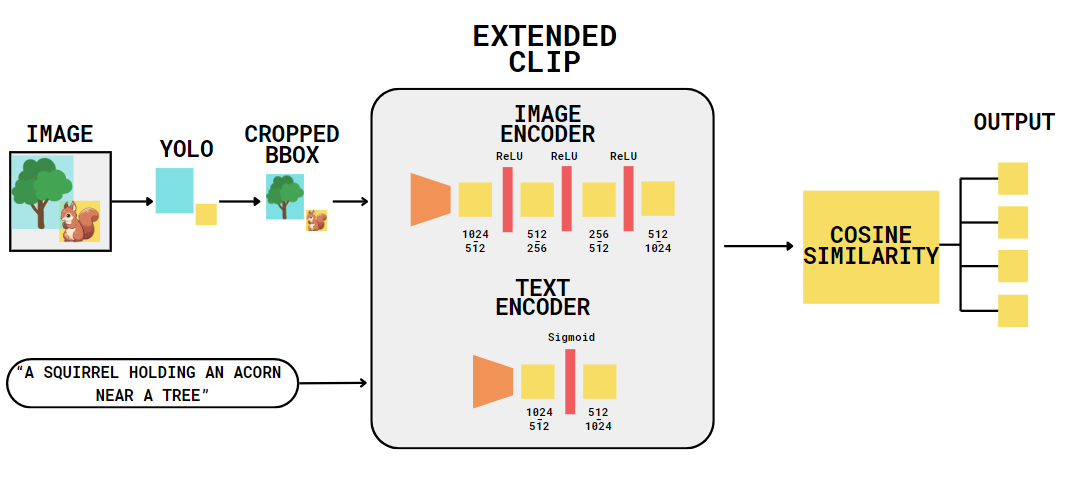

In [ ]:
class ExtendedClip(nn.Module):
  def __init__(self, device=None, norm = True, batch_size = 128):
    ''' Extended CLIP init method'''
    super().__init__()
    if device is None:
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
      self.device = device
    # Clip model initialization
    self.clipModel, self.preprocess = clip.load("RN50", device=self.device)
    self.in_features, self.out_features = 1024, 1024
    self.norm = norm
    self.batch_size = batch_size
    self.bias = False
    # Custom encoder initialization
    self.img_enc = Extended_Clip_img_enc().to(self.device)
    self.txt_enc = Extended_Clip_txt_enc().to(self.device)

  # input will be of the following shape: [([crop1_1, crop1_2, ..., crop1_N], [prompt1_1, prompt1_2, ... prompt1_N])]
  def forward(self, inputs):
    # Prepare output list
    net_output = list()

    # If input has more than one pair crops-prompts
    for single_input in inputs:
      input_crops = single_input[0]
      input_prompts = single_input[1]

      # Clip preprocess for images and prompts
      with torch.no_grad():
        input_crops_preprocessed = torch.stack([self.preprocess(crop) for crop in input_crops]).to(device=self.device)

      with torch.no_grad():
        input_prompts_preprocessed = clip.tokenize([prompt for prompt in input_prompts]).to(self.device)

      # Encoding of image and text
      image_features = self.img_enc(input_crops_preprocessed)
      text_features = self.txt_enc(input_prompts_preprocessed)

      # Normalization
      image_features = image_features / image_features.norm(dim=-1, keepdim=True).float()
      text_features = text_features / text_features.norm(dim=-1, keepdim=True).float()

      # Similarity matrix
      similarity_matrix = (text_features @ image_features.T).cpu()

      # Mean cosine similarity to reduce the similarity matrix into a 1 dimensional tensor
      mean_similarity_bbox = torch.mean(similarity_matrix, dim=0)

      # Append tensor to output list
      net_output.append(mean_similarity_bbox)

    return net_output

# Training and Test

Before discussing about the training and test procedure, let's talk about the cost function and the optimizer used by our model.

For the cost function we rely on a **Cross Entropy Loss**. In order to compute it, we define a list of predictions (a list of cosine similarity tensors that encodes the relation between a crop in the image and the corresponding text) and a tensor of ground truth values.

The ground truth tensor, as explained in the documentation of the method `cost_function()`, contains the correct index at which the ground truth bounding box is located.

Thanks to the `torch.nn.CrossEntropyLoss`, we can compare the corresponding cosine similiarity of the ground truth bounding box with the best cosine similarity in the group of bounding boxes.

The return value of the `cost_function()` is the mean loss value for the whole batch considered. In this way we can keep track of the mean value of the loss across a batch, avoiding increasing its value too much in relation to the samples.

For what regard the **optimizer**, we decided to use a simple Stochastic Gradient Descent, with some twist in the parameters: by previous knowledge acquired in the Optimization Technique course of the University of Trento, we decided to set a very small weight decay (in order to have a small but not too strong perturbation on the weights of the network due to optimization) and a higher momentum. Since the momentum helps the gradient in taking bigger steps when further away from the global optimum, an higher momentum value helps in increasing the distance traversed by the gradient in the first steps while helping in slowing down it when closer to the global optimum.

The learning rate we decided to use is the standard one defined by the library. This is due to the fact that, while trying other learning rates, we obtained more unstable performances. More precisely, we have seen that the values of the training loss function become more distant from those of the validation loss function and the accuracy functions, both training and validation, become more unstable, showing clear improvements only to worsen much later.

Furthermore, we used the standard learning rate because the risk of using a too high value is that the gradient could not be able to jump towards the global optimum, moving away from it. On the other side, instead, using a learning rate too small could lead to a lower improvement, stucking the gradient in a local minimum.

In [ ]:
def cost_function(pred, gt):
    '''
      Represents the cost function of our model.

      Args:
        pred: list of tensor of predictions. [tensor([bbox1, bbox2, ..., bboxM]), tensor([bbox1, bbox2, ..., bboxN])]. Each tensor represents the mean similarities between the bounding boxes detected by YOLO and the text
        gt: Tensor of the ground truths bounding boxes. tensor([1, 2]). In this case the first tensor has the second bounding boxes as it ground truth, while the second one has the ground truth in position 2

      Returns:
          float: avg(nn.CrossEntropyLoss), such that the cross entropy loss is computed for each element separately in order to deal with different number of classes (more bounding boxes detected)
    '''
    avg_loss = 0.0

    for batch_pred, batch_gt in zip(pred, gt):
      ln = nn.CrossEntropyLoss()(batch_pred, batch_gt)
      avg_loss = avg_loss + ln

    avg_loss = avg_loss / len(pred)

    return avg_loss

def optimizer(network, learn_r, weight_d, _momentum):
    '''
      This function returns the optimizer.
      We decided to go with a simple Stochastic Gradient Descent

      Args:
        network: the network, model
        learn_r: learning rate
        weight_d: weight_decay
        _momentum: momentum
    '''
    return optim.SGD(network.parameters(), lr=learn_r, weight_decay=weight_d, momentum=_momentum)

Let's now define the training and test step of our model, with the addition of some useful functions used in this section specifically.

In both steps we decided to enlight the accuracy (that represents the mean IOU between the prediction of the model and the corresponding ground truth bounding box) and the loss.

In order to do so we need to refine a little the batches contained in the loader we want to use:
- If an image has no bounding boxes detected by YOLO (that provides us the crops to forward to the network), we simply move to the next element of the batch;
- Since an image has more than one caption, we compute the bounding boxes with YOLO only one time, in order to build a secondary list effectively used in the training process with the useful samples;
- If a bounding box has no caption, we simply ignore it since we cannot generate it arbitrarily.

At the end of the batch refinement, we zip together the lists containing the crops with the corresponding texts and we pass them to the model.

We then apply the loss function and calculate the corresponding Mean Intersection Over Union between a predicted bounding boxes and its ground truth respectively.

The ground truth we consider in this training and test step is not the bounding box of the RefCOCOg dataset. In this process we took the bounding boxes retrieved by the object detector (YOLO in our case) and compare them with the real bounding box in the dataset using Intersection over Union. We will use as the ground truth the one with the higher value of Intersection Over Union.

At the end of the training/test step, we divide the value of the accuracy and the loss by the number of batches we iterated on, in order to have the corresponding value.

In [ ]:
def training_step(model, train_loader, yolo_model, loss_func, opt, device="cuda" if torch.cuda.is_available() else "cpu"):
  '''
  Training step of Extended CLIP architecture

  Args:
    model: instance of the model to use
    train_loader: train data loader in the training step considered
    yolo_model: instance of YOLO to retrieve bounding boxes
    loss_func: instance of the loss function
    opt: instance of the optimizer
    device: device where to move and run the training step
  '''
  training_accuracy = 0
  training_loss = 0
  samples = 0

  # Set model in training mode
  model.to(device)
  model.train()
  num_iter=0
  for batch in train_loader:

    (images, captions) = batch
    # If images and captions are not of the same size we have some inconsistency in the batch, so we skip it
    if len(images)!=len(captions):
      continue
    # real_img, real_cap and ground_truth are the lists used in the training process containing respectively the crops used,
    # the captions related to them and the ground truth bounding box index used in the loss function
    # all_boxes is needed to get the bounding box value predicted by the model in the latter steps
    # gt_bounding_box is needed to get the ground truth bounding box coordinates in the latter steps
    real_img, real_cap, ground_truth, all_boxes, gt_bounding_box = [], [], [], [], []

    # Refine the batch in order to have 3 lists for training:
    # One for images, one for texts and one for the ground truth bounding box related to the text in the image
    # The 3 lists have the same length. The images may have duplicates if there are more bounding boxes with text
    # or there is more than one text for a single bounding box
    for img_index in range(len(images)):
      single_img = images[img_index]

      with torch.no_grad():
        predicted_boxes = getBbox_fromYOLO(yolo_model, single_img)
        # If YOLO does not predict anything skip to the next image
        if(len(predicted_boxes) == 0):
          continue
        cropped_images = []

        # get cropped image around the bounding boxes returned by yolo
        for box_index in range(len(predicted_boxes)):
          bbox = predicted_boxes[box_index]

          # crop image around area and push it into the cropped_images list
          cropped = single_img.crop((bbox.tolist()))
          cropped_images.append(cropped)

      rel_cap = captions[img_index]
      for cap in rel_cap:
        # If we have no caption value, skip to next caption
        if cap['caption'] is None:
          continue
        real_img.append(cropped_images)
        all_boxes.append(predicted_boxes)
        gt_bbox = torch.tensor(cap['bbox']).to(device)
        gt_index = compute_gt_index(predicted_boxes, gt_bbox)

        ground_truth.append(gt_index)

        gt_bounding_box.append(predicted_boxes[gt_index])
        cap_list = cap['caption']
        single_bbox_cp = []
        # Compute the caption list related to the bouding box in case
        for cp in cap_list:
          single_bbox_cp.append(cp['raw'])

        real_cap.append(single_bbox_cp)

    # If no image was computed skip the prediction
    if len(real_img) == 0:
      continue

    # Build inputs of the model
    inputs = list(zip(real_img, real_cap))
    ground_truth = torch.tensor(ground_truth)

    samples += len(inputs)

    # Model inference
    model_output = model(inputs)

    # Compute loss
    loss = loss_func(model_output, ground_truth)
    training_loss += loss

    # Extract predicted bounding box by model
    index_of_bbox_predicted = torch.tensor([torch.argmax(pred) for pred in model_output])
    bbox_predicted = [box[index] for box, index in zip(all_boxes, index_of_bbox_predicted)]
    bbox_pred = torch.stack(bbox_predicted)

    # Compute accuracy
    acc = apply_iou(bbox_pred, gt_bounding_box)
    training_accuracy += acc

    opt.zero_grad()
    loss.backward()
    opt.step()

    num_iter = num_iter+1

  training_loss /= num_iter
  training_accuracy /= num_iter
  return training_loss, training_accuracy

def apply_iou(prediction, ground_truths, mean=True):
  '''
  Compute intersection over union on a list of elements

  Args:
    prediction: list of predictions
    ground_truths: list of ground truths
    mean: flag to understand if it should return the mean value or the whole list of values
  '''
  iou_list = []
  for pred_index in range(len(prediction)):
    iou_list.append(Metrics.bboxes_iou(prediction[pred_index], ground_truths[pred_index], True))
  iou_list = torch.tensor([iou_elem.item() for iou_elem in iou_list])
  if mean:
    return iou_list.mean().item()
  return iou_list

def compute_gt_index(predictions, ground_truth):
  '''
   Returns the index in the yolo predictions list that is most similar to
   the ground truth bounding box (i.e. has the higher IoU)
   The bounding boxes are in format xyxy
  '''
  iou_list = []
  for pred_index in range(len(predictions)):
    iou_list.append(Metrics.bboxes_iou(predictions[pred_index], ground_truth))
  return iou_list.index(max(iou_list))

def test_step(model, val_loader, yolo_model, loss_func, device="cuda" if torch.cuda.is_available() else "cpu"):
  '''
  Training step of Extended CLIP architecture

  Args:
    model: instance of the model to use
    val_loader: train data loader in the training step considered
    yolo_model: instance of YOLO to retrieve bounding boxes
    loss_func: instance of the loss function
    device: device where to move and run the training step
  '''
  test_loss, test_accuracy = 0, 0
  samples = 0

  # Set model in evaluation mode
  model.to(device)
  model.eval()

  with torch.inference_mode():
    num_iter=0
    for batch in val_loader:
      (images, captions) = batch
      # If images and captions are not of the same size we have some inconsistency in the batch, so we skip it
      if len(images)!=len(captions):
        continue
      # real_img, real_cap and ground_truth are the lists used in the training process containing respectively the crops used,
      # the captions related to them and the ground truth bounding box index used in the loss function
      # all_boxes is needed to get the bounding box value predicted by the model in the latter steps
      # gt_bounding_box is needed to get the ground truth bounding box coordinates in the latter steps
      real_img, real_cap, ground_truth, all_boxes, gt_bounding_box = [], [], [], [], []

      # Refine the batch in order to have 3 lists for training:
      # One for images, one for texts and one for the ground truth bounding box related to the text in the image
      # The 3 lists have the same length. The images may have duplicates if there are more bounding boxes with text
      # or there is more than one text for a single bounding box
      for img_index in range(len(images)):
        single_img = images[img_index]

        with torch.no_grad():
          predicted_boxes = getBbox_fromYOLO(yolo_model, single_img)
          # If YOLO does not predict anything skip to the next image
          if(len(predicted_boxes) == 0):
            continue
          cropped_images = []

          # get cropped image around the bounding boxes returned by yolo
          for box_index in range(len(predicted_boxes)):
            bbox = predicted_boxes[box_index]

            # crop image around area and push it into the cropped_images list
            cropped = single_img.crop((bbox.tolist()))
            cropped_images.append(cropped)

        rel_cap = captions[img_index]
        for cap in rel_cap:
          # If we have no caption value, skip to next caption
          if cap['caption'] is None:
            continue
          real_img.append(cropped_images)
          all_boxes.append(predicted_boxes)
          gt_bbox = torch.tensor(cap['bbox']).to(device)
          gt_index = compute_gt_index(predicted_boxes, gt_bbox)

          ground_truth.append(gt_index)

          gt_bounding_box.append(predicted_boxes[gt_index])
          cap_list = cap['caption']
          single_bbox_cp = []
          for cp in cap_list:
            single_bbox_cp.append(cp['raw'])

          real_cap.append(single_bbox_cp)

      # If no image was computed skip the prediction
      if len(real_img) == 0:
        continue

      inputs = list(zip(real_img, real_cap))
      ground_truth = torch.tensor(ground_truth)

      samples += len(inputs)

      # Model inference
      model_output = model(inputs)

      # Compute loss
      loss = loss_func(model_output, ground_truth)
      test_loss += loss

      # Extract predicted bounding box by model
      index_of_bbox_predicted = torch.tensor([torch.argmax(pred) for pred in model_output])
      bbox_predicted = [box[index] for box, index in zip(all_boxes, index_of_bbox_predicted)]
      bbox_pred = torch.stack(bbox_predicted)

      # Compute accuracy
      acc = apply_iou(bbox_pred, gt_bounding_box)
      test_accuracy += acc

      num_iter = num_iter+1

    test_loss /= num_iter
    test_accuracy /= num_iter
    return test_loss, test_accuracy

In [ ]:
# function used to save the weights of the model at each epoch
def save_network(model, epoch_label):
  save_filename = 'model_%s.pth' % epoch_label
  save_path = os.path.join('./', save_filename)
  torch.save(model.state_dict(), save_path)

In [ ]:
learning_rate = 0.01
weight_decay = 0.000001
momentum = 0.9

yoloModel = YOLO(yolo_path).to(device)
model = ExtendedClip().to(device)
# Freeze Clip components
for name, param in model.named_parameters():
  if param.requires_grad and 'clipModel' in name:
    param.requires_grad = False
train_loader, validation_loader, test_loader = get_data()
optim_instance = optimizer(model, learning_rate, weight_decay, momentum)

loading annotations into memory...
Done (t=6.02s)
creating index...
index created!
loading annotations into memory...
Done (t=5.69s)
creating index...
index created!
loading annotations into memory...
Done (t=6.30s)
creating index...
index created!
Total samples in training:  21899
Total Samples in validation:  1300
Total Samples in test:  2600
Samples used in training:  1500


We decided to train our model in different configurations:

We will present in this last part a showcase of the data we obtained by each training sequence counting separately:
- 1500 training samples for 10 epochs (in order to let the colab notebook execute on the Colab virtual machine)
- 1500 training samples for 20 epochs (executed on the Azure server granted)
- 3000 training samples for 30 epochs (executed on the Azure server granted)

As accuracy we decided to use the Mean Intersection Over Union, since it is a great indicator of the performances of our solution w.r.t. the task we have to accomplish. In fact, in order to understand if the Extended version of CLIP we developed is working correctly, we only need to understand how the predicted bounding box the model gives us is overlapped with the ground truth bounding box.

In [ ]:
# For each epoch, train the network and then compute evaluation results
num_epochs = 10

history_train_loss = []
history_train_accuracy = []
history_val_loss = []
history_val_accuracy = []

for epoch in range(1, num_epochs+1):

    # training loop
    train_loss, train_accuracy = training_step(model, train_loader, yoloModel, cost_function, optim_instance)
    history_train_loss.append(train_loss)
    history_train_accuracy.append(train_accuracy)

    # save the model weights
    save_network(model, str(epoch))

    # evaluation loop
    val_loss, val_accuracy = test_step(model, validation_loader, yoloModel, cost_function)
    history_val_loss.append(val_loss)
    history_val_accuracy.append(val_accuracy)

    print(f"================== EPOCH {epoch}/{num_epochs} =====================")
    print(f"Training Loss: {train_loss} Training mIOU: {train_accuracy}")
    print(f"Validation Loss: {val_loss} Validation mIOU: {val_accuracy}")

<ipython-input-7-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)
<ipython-input-9-6650a183b77a>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  bboxes = torch.tensor(bboxes)
<ipython-input-7-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


================== EPOCH 1/10 =====================
Training Loss: 1.5692766904830933 Training mIOU: 0.366732375777286
Validation Loss: 1.5732327699661255 Validation mIOU: 0.488242576951566
================== EPOCH 2/10 =====================
Training Loss: 1.5681957006454468 Training mIOU: 0.5336755928785905
Validation Loss: 1.6023566722869873 Validation mIOU: 0.5166974339796149
================== EPOCH 3/10 =====================
Training Loss: 1.5803638696670532 Training mIOU: 0.5101419363332831
Validation Loss: 1.6071972846984863 Validation mIOU: 0.5103588065375453
================== EPOCH 4/10 =====================
Training Loss: 1.572921633720398 Training mIOU: 0.5083192237045454
Validation Loss: 1.5699429512023926 Validation mIOU: 0.5025577350803043
================== EPOCH 5/10 =====================
Training Loss: 1.570480465888977 Training mIOU: 0.5104762263919996
Validation Loss: 1.5597699880599976 Validation mIOU: 0.4936768956806349
================== EPOCH 6/10 ==============

Let's sum up these results in a table before taking a look at them in a graphical representation:

| Epoch | Training Loss | Training Accuracy (mIOU) | Validation Loss | Validation Accuracy (mIOU) |
|-------|---------------|--------------------------|-----------------|-------------|
|   1   | 1.5692766904830933 | 0.366732375777286 | 1.5732327699661255 | 0.488242576951566 |
|   2   | 1.5681957006454468 | 0.5336755928785905 | 1.6023566722869873 | 0.5166974339796149 |
|   3   | 1.5803638696670532 | 0.5101419363332831 | 1.6071972846984863 | 0.5103588065375453 |
|   4   | 1.572921633720398 | 0.5083192237045454 | 1.5699429512023926 | 0.5025577350803043 |
|   5   | 1.570480465888977 | 0.5104762263919996 | 1.5597699880599976 | 0.4936768956806349 |
|   6   | 1.5528446435928345 | 0.4867383889530016 | 1.528956651687622 | 0.5046201153941776 |
|   7   | 1.4933860301971436 | 0.4841348690831143 | 1.4311596155166626 | 0.5085775904033495 |
|   8   | 1.440641164779663 | 0.4835862893125285 | 1.4326261281967163 | 0.48003065910028375 |
|   9   | 1.3841910362243652 | 0.4874453998130301 | 1.3858286142349243 | 0.48506546668384387 |
|  10   | 1.3989123106002808 | 0.4960223241992619 | 1.358229637145996 | 0.4871852993965149 |

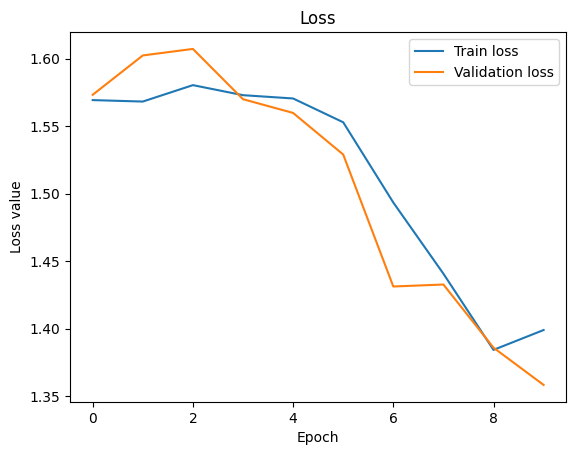

In [ ]:
history_train_loss_list = [h.item() for h in history_train_loss]
plt.plot(history_train_loss_list, label="Train loss")
plt.plot(history_val_loss, label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

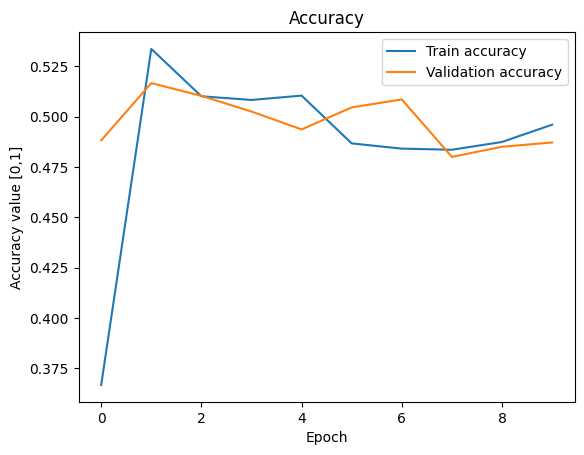

In [ ]:
plt.plot(history_train_accuracy, label="Train accuracy")
plt.plot(history_val_accuracy, label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy value [0,1]')
plt.legend()
plt.show()

## Training results

### 10 epochs with 1500 training samples

We attach to this cell the results of the training we mentioned above, just in case the output of the cell has been overridden.

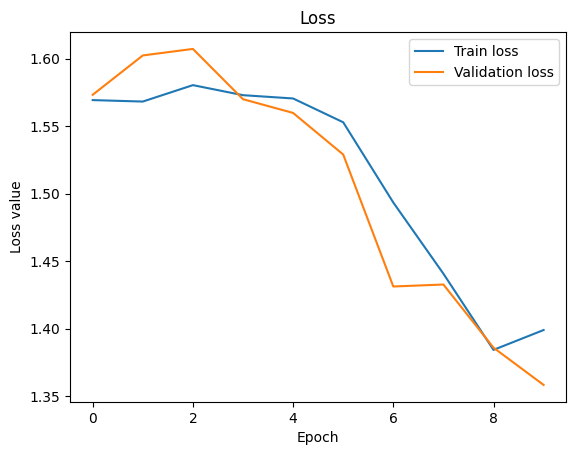

*Figure 5: Loss for training with 10 epochs and 1500 training samples*

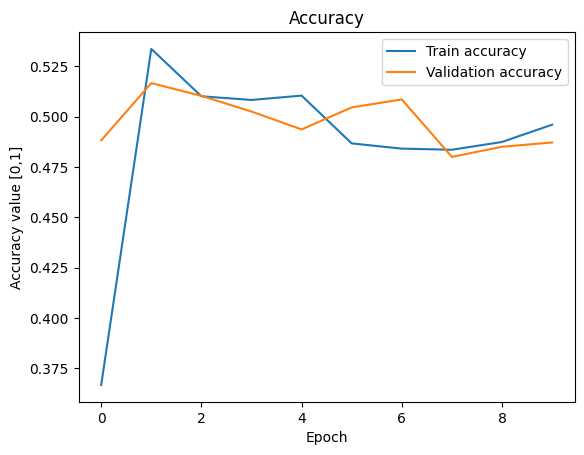

*Figure 6: Accuracy for training with 10 epochs and 1500 training samples*

We can notice that both losses decreases well while passing epoch even with a small number of them.

At first we can notice that the validation loss is a little worse than the training loss, but after very few epochs it starts to be a little better, following the trend of the training loss.

The two curves does not differ too much one from the other, which can help in understand that we do not incurr in overfitting, since neither loss tend to increase and move away from the other curve.

For the accuracy we can notice some strange behaviour since the validation accuracy does not tend to move away and remains at the same level. This is an indication that we need to increase the number of epochs in our training, in order to let the model learn more about the data increasing its accuracy.

### 20 epochs and 1500 training samples

Let's now discuss about the training with 1500 training samples and 20 epochs.

| Epoch | Training Loss | Training Accuracy (mIOU) | Validation Loss | Validation Accuracy (mIOU) |
|-------|---------------|--------------------------|-----------------|-------------|
|   1   | 1.5616179704666138 | 0.42252225720364117 | 1.6019585132598877 | 0.5182171593541685 |
|   2   | 1.5887619256973267 | 0.5413429801878722 | 1.5771960020065308 | 0.5529303447059963 |
|   3   | 1.5739861726760864 | 0.5272627757943195 | 1.5869616270065308 | 0.5243542842243029 |
|   4   | 1.5829392671585083 | 0.5303470608980759 | 1.6038347482681274 | 0.5145796459654103 |
|   5   | 1.5930308103561401 | 0.5108363887538081 | 1.557480812072754 | 0.5030709919722184 |
|   6   | 1.5300631523132324 | 0.5266389173010121 | 1.5387344360351562 | 0.49325382903866144 |
|   7   | 1.457198977470398 | 0.5029713343019071 | 1.4326778650283813 | 0.5049222033956776 |
|   8   | 1.3983643054962158 | 0.5119670085285021 | 1.4451682567596436 | 0.47643508600152057 |
|   9   | 1.4387147426605225 | 0.49517763827158057 | 1.4184281826019287 | 0.4734542538290438 |
|  10   | 1.4236811399459839 | 0.4959992572017338 | 1.4253860712051392 | 0.4978666137094083 |
|  11   | 1.3989644050598145 | 0.48247155935867975 | 1.3991665840148926 | 0.48683047683342645 |
|  12   | 1.4173376560211182 | 0.48039701516213623 | 1.4020682573318481 | 0.483106915069663 |
|  13   | 1.4224255084991455 | 0.4866845763247946 | 1.3958380222320557 | 0.49741327892179077 |
|  14   | 1.3681491613388062 | 0.5062118470668793 | 1.3569670915603638 | 0.4900845107824906 |
|  15   | 1.317914605140686 | 0.5160669360471808 | 1.3466038703918457 | 0.5046338089134382 |
|  16   | 1.3740718364715576 | 0.4976844528447027 | 1.3480956554412842 | 0.4894769690606905 |
|  17   | 1.3763641119003296 | 0.4980812098668969 | 1.2781767845153809 | 0.5213452149992404 |
|  18   | 1.3487902879714966 | 0.5128643707088802 | 1.3064628839492798 | 0.5158745503943899 |
|  19   | 1.3019057512283325 | 0.53073476449303 | 1.294937014579773 | 0.5249961225882821 |
|  20   | 1.3103256225585938 | 0.5289225630138231 | 1.3032283782958984 | 0.5255544392958932 |

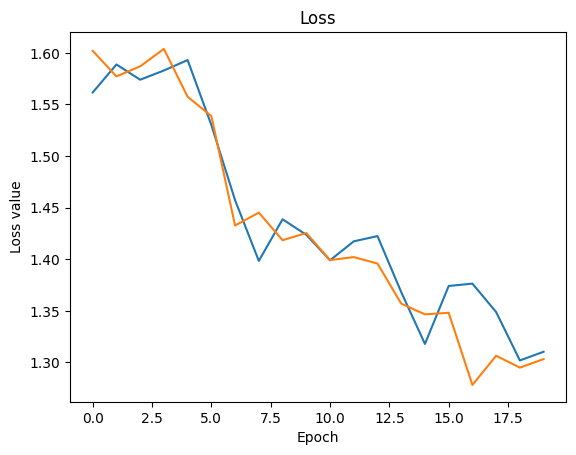

*Figure 7: Loss for training with 20 epochs and 1500 training samples*

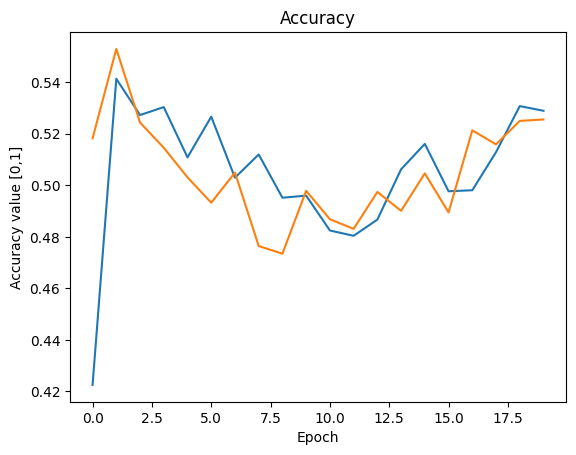

*Figure 8: Accuracy for training with 20 epochs and 1500 training samples*

With this new experiment, we can see how the observations about the losses (that have the same color as the examples above) are confirmed with a greater number of epochs. We can see that around the 15$^{th}$ epoch the validation loss worsen a bit, but it will still continue to decrease together with the training loss.

For what regards the accuracy, we can see a slightly improvement in the data. Effectively, the range of the accuracy of the prediction is not too large, but we can still see a perturbation in the middle stage of the training process.


### 30 epochs and 3000 training samples

Let's now discuss about the training with 3000 training samples and 300 epochs.

| Epoch | Training Loss | Training Accuracy (mIOU) | Validation Loss | Validation Accuracy (mIOU) |
|-------|---------------|--------------------------|-----------------|-------------|
|   1   | 1.5882776975631714 | 0.42518270148171317 | 1.5885969400405884 | 0.5456213719315 |
|   2   | 1.5890495777130127 | 0.5638147195180258 | 1.5785764455795288 | 0.5404567321141561 |
|   3   | 1.5467116832733154 | 0.5389236377345191 | 1.5074783563613892 | 0.518708942996131 |
|   4   | 1.4090864658355713 | 0.5257193545500437 | 1.3814146518707275 | 0.5129554463757409 |
|   5   | 1.3856834173202515 | 0.5159883108403948 | 1.3819870948791504 | 0.5158253914780087 |
|   6   | 1.3895002603530884 | 0.49980676240391203 | 1.3816664218902588 | 0.5089801424079471 |
|   7   | 1.378047227859497 | 0.5088858988549975 | 1.3745722770690918 | 0.5041800114843581 |
|   8   | 1.3734233379364014 | 0.502868072854148 | 1.3477084636688232 | 0.50755758550432 |
|   9   | 1.3530421257019043 | 0.5081997527016534 | 1.3398712873458862 | 0.516275069448683 |
|  10   | 1.3525946140289307 | 0.5141737421353658 | 1.3420954942703247 | 0.5169693900479211 |
|  11   | 1.35471510887146 | 0.5195570362938775 | 1.3340312242507935 | 0.5315720445579952 |
|  12   | 1.3334388732910156 | 0.5282562990983327 | 1.3153655529022217 | 0.5266624086432987 |
|  13   | 1.3345907926559448 | 0.523296390639411 | 1.3325881958007812 | 0.5396725522147284 |
|  14   | 1.3358105421066284 | 0.5274357385105557 | 1.3016057014465332 | 0.5404362108972337 |
|  15   | 1.3315575122833252 | 0.5277175406614939 | 1.290122151374817 | 0.5379562536875407 |
|  16   | 1.310484528541565 | 0.5353411085075802 | 1.2857639789581299 | 0.544544294807646 |
|  17   | 1.3057714700698853 | 0.5392791185114119 | 1.2895972728729248 | 0.5433868116802639 |
|  18   | 1.2982643842697144 | 0.5447113904688093 | 1.257253646850586 | 0.5559053533607059 |
|  19   | 1.3093771934509277 | 0.5584168480502234 | 1.2702535390853882 | 0.5592934105131361 |
|  20   | 1.3281046152114868 | 0.5495040860440996 | 1.3130723237991333 | 0.5451096124119229 |
|  21   | 1.2714110612869263 | 0.5559134364128113 | 1.2457544803619385 | 0.5611804862817128 |
|  22   | 1.2803233861923218 | 0.5436793665091196 | 1.3087223768234253 | 0.5467560523086124 |
|  23   | 1.2907359600067139 | 0.5653151777055528 | 1.2433857917785645 | 0.5738125383853913 |
|  24   | 1.2661042213439941 | 0.5731007695198059 | 1.3850162029266357 | 0.5329723331663344 |
|  25   | 1.3260905742645264 | 0.5369278232256571 | 1.2858867645263672 | 0.5699999584092035 |
|  26   | 1.2716124057769775 | 0.5697896401087443 | 1.2701194286346436 | 0.5799173646503024 |
|  27   | 1.260285496711731 | 0.5650844275951385 | 1.238259196281433 | 0.5837746547328101 |
|  28   | 1.2695398330688477 | 0.5750057134363387 | 1.206435203552246 | 0.5972200671831767 |
|  29   | 1.2483407258987427 | 0.5716556118594276 | 1.286869764328003 | 0.5918123023377524 |
|  30   | 1.2377036809921265 | 0.5793744623661041 | 1.193329930305481 | 0.592979598707623 |

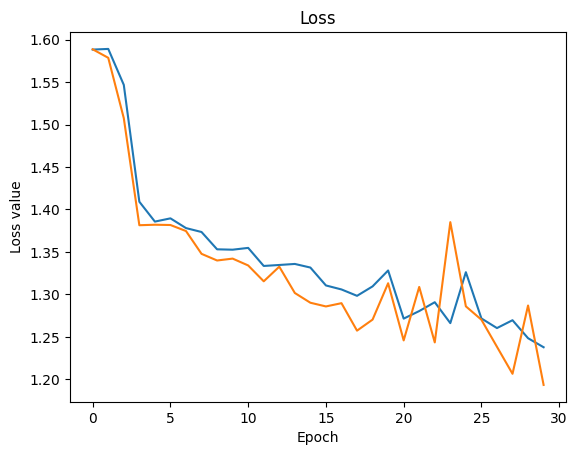

*Figure 9: Loss for training with 30 epochs and 3000 training samples*

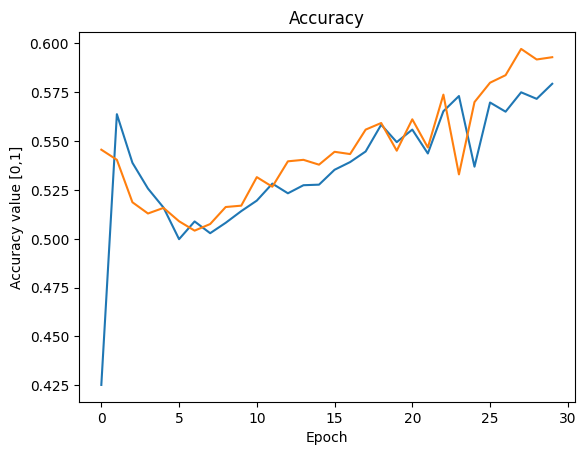

*Figure 10: Accuracy for training with 30 epochs and 3000 training samples*

Despite some spikes in the last epochs for the validation loss, we can see that with even more epochs the loss decreases for both data loader.

In addition we can see a significant improvement in accuracy, which is finally able to improve w.r.t. the initial value of the first epoch of training.


# Evaluations

To evaluate the performance of both systems we developed two similar evaluation loop. The one for baseline consists in the following steps:

* We take all the test loader, going to evaluate the models on the whole test set.
* We refine it in such a way that we create a 1-1-1 correspondence between  an image, one of its bounding boxes and a caption of those associated with it.
* For every correspondence we run the inference method of the `Baseline` class.
* We gather data to compute metrics useful to understand the performance of the model.

Then, with regard to the evaluation loop of our solution, the main difference between the one just cited (except the fact that we execute the `forward` method of `ExtendedClip`) is that, instead of creating an element for each caption, we create a correspondence only between image and bounding box, associating all the captions to it.

Talking about the metrics used in this section, we used:
* **Total Intersection over Union** (`iou`): metric that, associated with the next one and taking advantage of the fact that the Intersection over Union has a range of [0,1], gives an idea of how many samples the model inferred correctly.
* **Number of samples** (`samples`): it shows how many samples (image-bounding_box-caption for `Baseline` and image-bounding_box[-captions] for `ExtendedClip`) has analyzed.
* **Mean Intersection over Union** (`miou`): metric used to compute the accuracy of the model w.r.t. the ground truth, understanding the extent to which the model makes correct predictions of target bounding boxes.
* **Mean Cosine Similarity** (`mean_cos_sim`): metric that shows how much the predicted bounding boxes are similar to the ones of the ground truth. This is useful to differentiate situations in which, for example, there is a low Intersection Over Union, but with an high Cosine Similarity. In that case we can understand that in that situation the model has not tried a random bounding box, but it found very similar targets, maybe due to an encoding error (e.g., sentence referred to an image with similar objects).

## Baseline Evaluation

Since for the baseline there is not a training step, the evaluation step gives always the same results for every execution.

| Total Intersection over Union | Number of samples | Mean Intersection over Union | Mean Cosine Similarity |
|---------------|--------------------------|-----------------|-------------|
| 4902.945704222882 | 9602 | 0.5112092686005127 | 0.8690382598514632 |

Analyzing the data we can notice that the `Baseline` model has obtained an increment of of performance w.r.t. the state of the art (which has an accuracy  near to 0.3)

In [ ]:
def baseline_eval(test_loader):
  # Setup of the environment
  device = "cuda" if torch.cuda.is_available() else "cpu"
  baseline = Baseline()
  clipModel, preprocess = clip.load("RN50", device=device)

  total_iou = []
  mean_iou = 0.0
  cos_sim = []
  samples = 0

  with torch.inference_mode():
    num_iter=0
    for batch in test_loader:
      (images, captions) = batch
      # If images and captions are not of the same size we have some inconsistency in the batch, so we skip it
      if len(images)!=len(captions):
        continue
      # Initialize lists for predictions and ground_truths
      predictions, ground_truth_bboxes = [], []

      # Cycle on each element of the batch in order to pass to the Baseline the correct couple of image and caption, while keeping track
      # of the corresponding ground truth
      for img_index in range(len(images)):
        single_img = images[img_index]

        rel_cap = captions[img_index]
        printable_captions = []
        for cap in rel_cap:
          # If we have no caption value, skip to next caption
          if cap['caption'] is None:
            continue
          gt_bbox = torch.tensor(cap['bbox']).to(device)

          cap_list = cap['caption']
          for cp in cap_list:
            prediction = baseline.inference(single_img, cp['raw'])
            # If prediction is the default one for no YOLO results, skip to the next image
            if(torch.equal(prediction,torch.tensor([0, 0, 640, 640], device=device))):
              continue
            # Only for the first 3 batches, save the first image text
            if(num_iter<3 and img_index==0):
              printable_captions.append(cp['raw'])

            #Get the prediction crop from the image and compute its encoding
            predictions.append(prediction)
            pred_crop = single_img.crop((prediction.tolist()))
            preprocess_pred_crop = torch.tensor(preprocess(pred_crop), device=device).unsqueeze(0)
            encoded_pred_crop =clipModel.encode_image(preprocess_pred_crop)

            # Get the ground truth crop from the image and compute its encoding
            ground_truth_bboxes.append(gt_bbox)
            gt_crop = single_img.crop((gt_bbox.tolist()))
            preprocess_gt_crop = torch.tensor(preprocess(gt_crop),device=device).unsqueeze(0)
            encoded_gt_crop = clipModel.encode_image(preprocess_gt_crop)

            # Compute the cosine similarity between prediction and ground truth
            cos_sim.append(F.cosine_similarity(encoded_gt_crop, encoded_pred_crop).item())

        # For the first 3 batches, we display the first image with the first caption, in order to compare the results
        if(num_iter<3 and img_index == 0):
          I = np.asarray(single_img)

          plt.imshow(I)
          plt.gca().add_patch(Rectangle((ground_truth_bboxes[0][0].item(), ground_truth_bboxes[0][1].item()), (ground_truth_bboxes[0][2].item()-ground_truth_bboxes[0][0].item()), (ground_truth_bboxes[0][3].item()-ground_truth_bboxes[0][1].item()), edgecolor="green", facecolor="none", lw=4))
          plt.gca().add_patch(Rectangle((predictions[0][0].item(), predictions[0][1].item()),(predictions[0][2].item()-predictions[0][0].item()), (predictions[0][3].item()-predictions[0][1].item()),edgecolor="red",facecolor="none",lw=4))
          plt.tight_layout()
          plt.show()
          print(printable_captions[0])

      # If no image was computed skip the prediction
      if(len(ground_truth_bboxes)==0):
        continue

      samples += len(ground_truth_bboxes)

      # Compute intersection over union
      iou_values = apply_iou(predictions, ground_truth_bboxes, mean=False)
      total_iou.extend(iou_values.tolist())
      mean_iou += iou_values.mean().item()

      num_iter = num_iter + 1

      torch.cuda.empty_cache()

  return sum(total_iou), samples, mean_iou/num_iter, sum(cos_sim)/samples

<ipython-input-8-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)
<ipython-input-10-6650a183b77a>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  bboxes = torch.tensor(bboxes)
<ipython-input-15-ad1ecba139d6>:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(pred_bbox, device = self.device)
<ipython-input-23-3bbd56544880>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().det

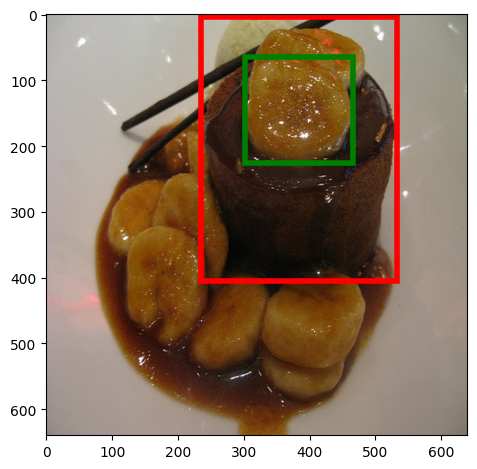

bananas on top of a cake


<ipython-input-8-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


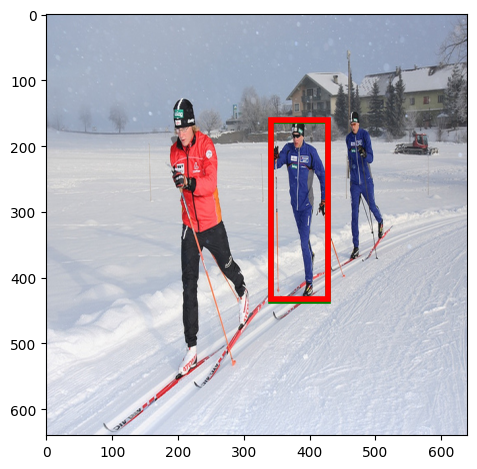

A skier with a blue suite between two other skiers.


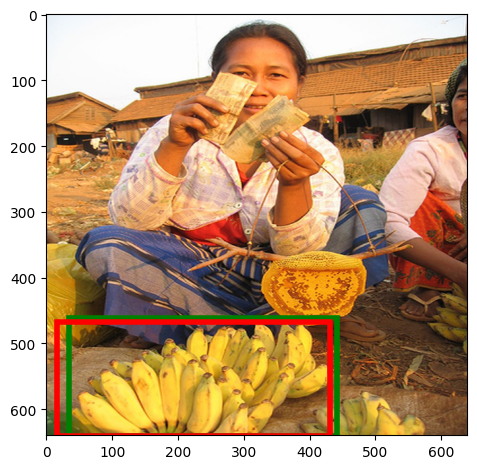

the bananas sitting in front of the woman
Total Intersection over union:  4886.344311438377
Samples analyzed:  9543
Mean Intersection over union:  0.5126070991540567
Mean cosine similarity:  0.8699957439762784


In [ ]:
iou, samples, miou, mean_cos_sim = baseline_eval(test_loader)
print("Total Intersection over union: ",iou)
print("Samples analyzed: ",samples)
print("Mean Intersection over union: ",miou)
print("Mean cosine similarity: ",mean_cos_sim)

## Model Evaluation

With regard to the evaluation of `ExtendedClip` we can show the different results obtained during the various executions (consider `e` for epoch and `ts` for training samples):

| Execution | Total Intersection over Union | Number of samples | Mean Intersection over Union | Mean Cosine Similarity |
|-----------|---------------|--------------------------|-----------------|-------------|
| 10 e - 1500 ts | 2791.893519561563 | 4992 | 0.5582801638505398 | 0.8704003065060346 |
| 20 e - 1500 ts | 2518.551670724177 | 4992 | 0.5045044834797199 | 0.8529139787722857 |
| 30 e - 3000 ts | 2441.5969567738357 | 4992 | 0.48934162809298587 | 0.8458396226931841 |

Apparently, from what we can see, it seems that accuracy results with increasing epochs and training samples deteriorate, as does Cosine Similarity.
We can probably attribute this to the trend of accuracy during training and evaluation.

In [ ]:
def get_list_cos_sim(clipModel, clipPreprocess, images, prediction, ground_truths, device="cuda" if torch.cuda.is_available() else "cpu"):
  '''
  Create the cosine similarity list for the ExtendedCLIP evaluation step

  Args:
    clipModel: CLIP model used for encoding
    clipPreprocess: CLIP preprocess used for encoding
    images: list of original images
    prediction: list of model predictions
    ground_truths: list of ground truths
  '''
  list_cos_sim = []
  for pred_index in range(len(prediction)):
    # Get prediction crop from original image and encode it with CLIP
    pred_crop = images[pred_index].crop((prediction[pred_index].tolist()))
    preprocess_pred_crop = torch.tensor(clipPreprocess(pred_crop), device=device).unsqueeze(0)
    encoded_pred_crop = clipModel.encode_image(preprocess_pred_crop)

    # Get ground truth crop from original image and encode it with CLIP
    gt_crop = images[pred_index].crop((ground_truths[pred_index].tolist()))
    preprocess_gt_crop = torch.tensor(clipPreprocess(gt_crop),device=device).unsqueeze(0)
    encoded_gt_crop = clipModel.encode_image(preprocess_gt_crop)

    # Append computed cosine similarity
    list_cos_sim.append(F.cosine_similarity(encoded_gt_crop, encoded_pred_crop).item())

  return list_cos_sim

In [ ]:
def model_eval(model, test_loader, yolo_model, device="cuda" if torch.cuda.is_available() else "cpu"):
  '''
  Extended CLIP evaluation method

  Args:
    model: instance of the model used for evaluation
    test_loader: test dataloader instance used for evaluation
    yolo_model: instance of YOLO used for object detection
  '''
  total_iou = []
  mean_iou = 0.0
  cos_sim = []
  samples = 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    num_iter=0
    for batch in test_loader:
      (images, captions) = batch
      # If images and captions are not of the same size we have some inconsistency in the batch, so we skip it
      if len(images)!=len(captions):
        continue
      # real_img, real_cap and ground_truth are the lists used in the training process containing respectively the crops used,
      # the captions related to them and the ground truth bounding box index used in the loss function
      # all_boxes is needed to get the bounding box value predicted by the model in the latter steps
      # gt_bounding_box is needed to get the ground truth bounding box coordinates in the latter steps
      # complete_image_list is used for the cosine similarity computation
      real_img, real_cap, ground_truth, all_boxes, gt_bounding_box = [], [], [], [], []
      complete_image_list = []

      # Refine the batch in order to have 3 lists for training:
      # One for images, one for texts and one for the ground truth bounding box related to the text in the image
      # The 3 lists have the same length. The images may have duplicates if there are more bounding boxes with text
      # or there is more than one text for a single bounding box
      for img_index in range(len(images)):
        single_img = images[img_index]

        with torch.no_grad():
          predicted_boxes = getBbox_fromYOLO(yolo_model, single_img)
          # If YOLO does not predict anything skip to the next image
          if(len(predicted_boxes) == 0):
            continue
          cropped_images = []

          # get cropped image around the bounding boxes returned by yolo
          for box_index in range(len(predicted_boxes)):
            bbox = predicted_boxes[box_index]

            # crop image around area and push it into the cropped_images list
            cropped = single_img.crop((bbox.tolist()))
            cropped_images.append(cropped)

        rel_cap = captions[img_index]
        for cap in rel_cap:
          # If we have no caption value, skip to next caption
          if cap['caption'] is None:
            continue
          complete_image_list.append(single_img)
          real_img.append(cropped_images)
          all_boxes.append(predicted_boxes)
          gt_bbox = torch.tensor(cap['bbox']).to(device)
          gt_index = compute_gt_index(predicted_boxes, gt_bbox)

          ground_truth.append(gt_index)

          gt_bounding_box.append(predicted_boxes[gt_index])
          cap_list = cap['caption']
          single_bbox_cp = []
          for cp in cap_list:
            single_bbox_cp.append(cp['raw'])
          real_cap.append(single_bbox_cp)

      # If no image was computed skip the prediction
      if len(real_img) == 0:
        continue

      inputs = list(zip(real_img, real_cap))
      ground_truth = torch.tensor(ground_truth)

      samples += len(inputs)

      # Model inference
      model_output = model(inputs)

      # Extract predicted bounding box by model
      index_of_bbox_predicted = torch.tensor([torch.argmax(pred) for pred in model_output])
      bbox_predicted = [box[index] for box, index in zip(all_boxes, index_of_bbox_predicted)]
      bbox_pred = torch.stack(bbox_predicted)

      # For the first 3 batches, we display the first image with the set of captions, in order to compare the results
      if(num_iter < 3):
        I = np.asarray(complete_image_list[0])

        plt.imshow(I)
        plt.gca().add_patch(Rectangle((gt_bounding_box[0][0].item(), gt_bounding_box[0][1].item()), (gt_bounding_box[0][2].item()-gt_bounding_box[0][0].item()), (gt_bounding_box[0][3].item()-gt_bounding_box[0][1].item()), edgecolor="green", facecolor="none", lw=4))
        plt.gca().add_patch(Rectangle((bbox_pred[0][0].item(), bbox_pred[0][1].item()),(bbox_pred[0][2].item()-bbox_pred[0][0].item()), (bbox_pred[0][3].item()-bbox_pred[0][1].item()),edgecolor="red",facecolor="none",lw=4))
        plt.tight_layout()
        plt.show()
        print(real_cap[0])

      # Compute cosine similarity and intersection over union
      cos_sim.extend(get_list_cos_sim(model.clipModel, model.preprocess, complete_image_list, bbox_pred, gt_bounding_box))
      iou_values = apply_iou(bbox_pred, gt_bounding_box, mean=False)

      total_iou.extend(iou_values.tolist())
      mean_iou += iou_values.mean().item()

      num_iter = num_iter+1

    return sum(total_iou), samples, mean_iou/num_iter, sum(cos_sim)/samples

<ipython-input-8-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


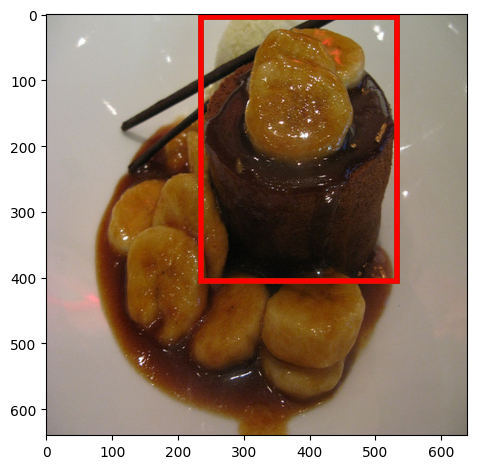

['bananas on top of a cake', 'A caramel doused banana on a chocolate cake.']


<ipython-input-25-ed442b6ed715>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preprocess_pred_crop = torch.tensor(clipPreprocess(pred_crop), device=device).unsqueeze(0)
<ipython-input-25-ed442b6ed715>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preprocess_gt_crop = torch.tensor(clipPreprocess(gt_crop),device=device).unsqueeze(0)
<ipython-input-8-4d522137aa9e>:71: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(desired_size, Image.ANTIALIAS)


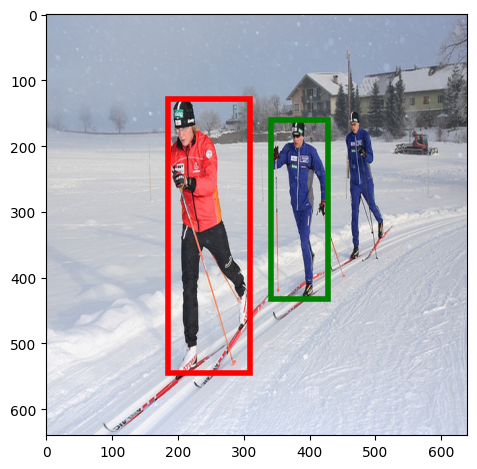

['A skier with a blue suite between two other skiers.', 'A cross-country skier situated in between two other skiers.']


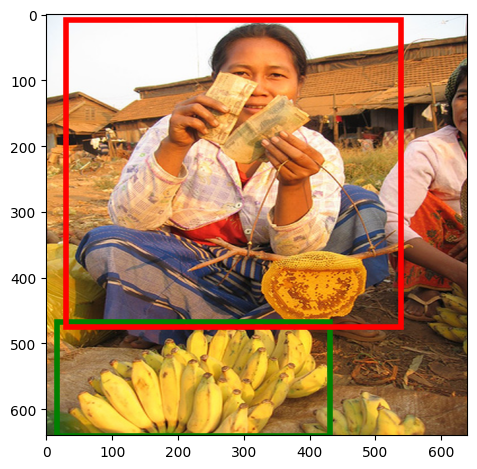

['the bananas sitting in front of the woman', 'larger bunch of bananas']
Total Intersection over union:  2791.893519561563
Samples analyzed:  4992
Mean Intersection over union:  0.5582801638505398
Mean cosine similarity:  0.8704003065060346


In [ ]:
iou, samples, miou, mean_cos_sim = model_eval(model, test_loader, yoloModel)
print("Total Intersection over union: ",iou)
print("Samples analyzed: ",samples)
print("Mean Intersection over union: ",miou)
print("Mean cosine similarity: ",mean_cos_sim)

# Conclusion and Future works

This report outlines our approach to the visual grounding task, starting with the definition of a baseline and subsequently introducing an original architecture aimed at surpassing its limitations and maximizing its potential.

Our approach has proven to be robust, yielding excellent results even from the baseline, with an accuracy surpassing that reported in reference papers. The loss curves exhibit gradual descent during both training and validation, converging after the initial 15 epochs.

However, the accuracy values tend to plateau early on and do not show significant improvement in subsequent epochs. To enhance our proposed solution, we plan to implement the following modifications in the future:

* Data Augmentation: Incorporating additional data augmentation techniques can enhance model generalization.
* LSTM Instead of MLP for Text: Replacing the MLP with an LSTM for text processing may address focus-related issues.
* Handling Missing COCO Captions: Exploring the use of a text generator similar to the one presented in “Pseudo-Q: Generating Pseudo Language Queries for Visual Grounding” could help resolve missing caption problems.

In summary, while our current approach shows promise, these future enhancements will contribute to refining our solution and addressing specific challenges.

# References
[1] Yu, Licheng & Poirson, Patrick & Yang, Shan & Berg, Alexander & Berg, Tamara. (2016). Modeling Context in Referring Expressions. 9906. 69-85. 10.1007/978-3-319-46475-6_5. \\
[2] Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish
Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, et al. Learning transferable visual models from
natural language supervision. In International conference on machine learning, pages 8748–8763. PMLR,
2021.
